Academic Integrity and Learning Statement

By submitting my work, I confirm that:

1. The code, analysis, and documentation in this notebook are my own work and reflect my own understanding.
2. I am prepared to explain all code and analysis included in this submission.

If I used assistance (e.g., AI tools, tutors, or other resources), I have:

- Clearly documented where and how external tools or resources were used in my solution.
- Included a copy of the interaction (e.g., AI conversation or tutoring notes) in an appendix.

I acknowledge that:

- I may be asked to explain any part of my code or analysis during evaluation.
- Misrepresenting assisted work as my own constitutes academic dishonesty and undermines my learning.

In [1]:
# Import core python libraries
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import custom python files
import proj_utils_logging as plogger
import proj_utils_data_loader as dloader
import proj_configs as pconfigs
import proj_utils_plots as pplots
import proj_utils_feat_engg as pfengg

In [2]:
# Enable auto-reload extension
%load_ext autoreload
# Automatically reload all modules before executing code
%autoreload 2

In [3]:
# Check software specs
dict_sw_version = {
    'python': os.popen('python --version').read().strip(),
    'numpy': np.__version__,
    'pandas': pd.__version__
}

for key, value in dict_sw_version.items():
    print(f'{pplots.beautify(key, 1)} version is: {pplots.beautify(value)}')


python version is: Python 3.13.5
numpy version is: 2.1.3
pandas version is: 2.2.3


In [4]:
logger = plogger.get_logger()
logger.debug(f"Initialised logging for {pconfigs.PROJECT_NAME} project.")

df_raw_train:
df_raw_test:
df_raw_all:
df_raw_target:
df_train:
df_test:
X_train:
X_val:
y_train:
y_val:


In [5]:
df_raw_train = dloader.load_data(pconfigs.TRAIN_FILE, True)
df_raw_test = dloader.load_data(pconfigs.TEST_FILE, True)

[INFO][load_data] Loading data from path: data/house-prices.csv
[INFO][load_data] Loaded train data with shape: (2430, 82)
[INFO][load_data] Successfully loaded data from path: data/house-prices.csv
[INFO][load_data] Loading data from path: data/house-prices-test.csv
[INFO][load_data] Loaded train data with shape: (500, 81)
[INFO][load_data] Successfully loaded data from path: data/house-prices-test.csv


In [6]:
df_raw_train.sample(3)

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
8,2320,527108040,60,RL,72.0,10463,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,239900
1423,1656,527356050,60,RL,80.0,10793,Pave,NaN,Reg,Lvl,...,0,NaN,GdWo,NaN,0,4,2007,WD,Normal,152000
1553,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,179665


In [7]:
insignificant_cols = ['Order', 'PID']
target_col = 'SalePrice'
ignorables_cols = insignificant_cols + [target_col]
ordinal_cols = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
temporal_cols_name_pattern = ['Yr', 'Year']
low_cardinality_cols = [cname for cname in df_raw_train.columns
                        if df_raw_train[cname].nunique() < 10 and
                        df_raw_train[cname].dtype == "object"]

In [8]:
df_raw_all, df_raw_target = dloader.merge_train_test_data(
    df_raw_train,
    df_raw_test,
    insignificant_cols,
    target_col
)

# Split into train and test
df_train = df_raw_all[df_raw_all['is_train'] == 1].iloc[:, :-1]
df_test = df_raw_all[df_raw_all['is_train'] == 0].iloc[:, :-1]

# Classify features
feature_categories = pfengg.classify_columns(
    df=df_train,
    n_cat_threshold=pconfigs.CATEGORICAL_CARDINALITY_THRESHOLD_ABS_VAL,
    threshold_type=pconfigs.CATEGORICAL_CARDINALITY_THRESHOLD_TYPE_ABS,
    cols_to_ignore=ignorables_cols,
    temporal_cols_name_pattern=temporal_cols_name_pattern,
    ordinal_cols=ordinal_cols
)

# Get column categories
(cols_num_continuous, n_cols_num_continuous, cols_num_discrete, n_cols_num_discrete,
 cols_cat_nominal, n_cols_cat_nominal, cols_cat_ordinal, n_cols_cat_ordinal,
 cols_object, n_cols_object, cols_temporal, n_cols_temporal,
 cols_binary, n_cols_binary, cols_low_cardinality, n_cols_low_cardinality) = pfengg.get_cols_as_tuple(feature_categories)


[INFO][merge_train_test_data] Merging train data shape: (2430, 82) and test data shape: (500, 81)
[INFO][merge_train_test_data] Dropped columns: ['Order', 'PID']
[INFO][merge_train_test_data] Merged data shape: (2930, 80)
[WARNING][classify_columns] Matching Col Type Not Found for: MasVnrType, so casting as Object type.
[WARNING][classify_columns] Matching Col Type Not Found for: Electrical, so casting as Object type.
[WARNING][classify_columns] Matching Col Type Not Found for: GarageType, so casting as Object type.
[WARNING][classify_columns] Matching Col Type Not Found for: GarageFinish, so casting as Object type.
[WARNING][classify_columns] Matching Col Type Not Found for: Fence, so casting as Object type.
[WARNING][classify_columns] Matching Col Type Not Found for: MiscFeature, so casting as Object type.
[INFO][classify_columns] Feature Type Summary:
[INFO][classify_columns] Numerical_Continuous Features (21):
[INFO][classify_columns] ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtF

In [9]:
n_total = df_train.shape[1] - len(ignorables_cols)

print(f"="*80)
print(f"Total raw columns = {pplots.beautify(str(len(df_train.columns)))} \nNumerical Continuous = {pplots.beautify(n_cols_num_continuous)} \nNumerical Discrete = {pplots.beautify(n_cols_num_discrete)} \nCategorical Nominal = {pplots.beautify(n_cols_cat_nominal)} \nCategorical Ordinal = {pplots.beautify(n_cols_cat_ordinal)} \nObject/String = {pplots.beautify(n_cols_object)} \nTemporal = {pplots.beautify(n_cols_temporal)} \nBinary = {pplots.beautify(n_cols_binary)}")

print(f"="*80)
print(f"Any inconsistencies detected?[True/False] = {pplots.beautify('True', 3) if n_total != len(df_train.columns) - len(ignorables_cols) else pplots.beautify('False', 1)}")
print(f'='*80)

Total raw columns = 79 
Numerical Continuous = 21 
Numerical Discrete = 9 
Categorical Nominal = 17 
Categorical Ordinal = 18 
Object/String = 7 
Temporal = 4 
Binary = 3
Any inconsistencies detected?[True/False] = False


In [10]:
df_raw_all, df_raw_target = dloader.merge_train_test_data(df_raw_train, df_raw_test, insignificant_cols, target_col)
df_raw_all.shape, df_raw_target.shape

[INFO][merge_train_test_data] Merging train data shape: (2430, 83) and test data shape: (500, 82)
[INFO][merge_train_test_data] Dropped columns: ['Order', 'PID']
[INFO][merge_train_test_data] Merged data shape: (2930, 80)


((2930, 80), (2430,))

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train,
    df_raw_target,
    test_size=pconfigs.VALIDATION_SIZE,
    random_state=pconfigs.RANDOM_STATE
)

In [12]:
# Calculate the number of NaN values for each column
nan_counts = df_train.isna().sum()

# Filter only columns that have NaN values and sort by the number of NaNs
cols_with_nans = nan_counts[nan_counts > 0].index.tolist()
print(f"Columns with NaNs: = {pplots.beautify(str(len(cols_with_nans)))}/{pplots.beautify(n_total)}")
print(f"And they are: {cols_with_nans}")

Columns with NaNs: = 27/76
And they are: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [13]:
df_cardinality = pfengg.get_cardinality_df(df_train)

In [14]:
df_cardinality

,col_name,notnull_pct,null_pct,unique_pct
MSSubClass,MSSubClass,1.000,0.000,0.007
MSZoning,MSZoning,1.000,0.000,0.003
LotFrontage,LotFrontage,0.827,0.173,0.050
LotArea,LotArea,1.000,0.000,0.698
Street,Street,1.000,0.000,0.001
...,...,...,...,...
MiscVal,MiscVal,1.000,0.000,0.014
MoSold,MoSold,1.000,0.000,0.005
YrSold,YrSold,1.000,0.000,0.002
SaleType,SaleType,1.000,0.000,0.004


In [15]:
pplots.plot_cardinality(df_cardinality, pconfigs.CATEGORICAL_CARDINALITY_THRESHOLD_ABS_VAL, threshold_used=pconfigs.CATEGORICAL_CARDINALITY_THRESHOLD_TYPE_ABS, type_of_cols='all', figsize=(20, 6))

Saving figure to /Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_cardinality_all_20250723_183722_238.png


/Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_cardinality_all_20250723_183722_238.png

In [16]:
# Zoom into cols having NaNs only
pplots.plot_cardinality(df_cardinality[df_cardinality['col_name'].isin(cols_with_nans)], pconfigs.CATEGORICAL_CARDINALITY_THRESHOLD_ABS_VAL, threshold_used=pconfigs.CATEGORICAL_CARDINALITY_THRESHOLD_TYPE_ABS, type_of_cols="NaN", figsize=(10, 6))

Saving figure to /Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_cardinality_NaN_20250723_183723_162.png


/Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_cardinality_NaN_20250723_183723_162.png

In [17]:
df_train[cols_num_continuous].isnull().sum().sort_values(ascending=False)

LotFrontage      420
MasVnrArea        20
BsmtFullBath       2
BsmtHalfBath       2
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
GarageCars         1
GarageArea         1
WoodDeckSF         0
ScreenPorch        0
3SsnPorch          0
EnclosedPorch      0
OpenPorchSF        0
GrLivArea          0
LotArea            0
LowQualFinSF       0
2ndFlrSF           0
1stFlrSF           0
MiscVal            0
dtype: int64

In [18]:
# Creating a copy of the raw data to impute missing values for plotting purposes only (as NaNs are not plotted)
df_imputed_for_plots = df_train.copy()
df_imputed_for_plots[cols_num_continuous] = df_imputed_for_plots[cols_num_continuous].fillna(0)
most_frequent = df_imputed_for_plots[cols_num_discrete].mode().iloc[0]
df_imputed_for_plots[cols_num_discrete] = df_imputed_for_plots[cols_num_discrete].fillna(most_frequent)

In [19]:
# correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")
correlation_plot = pplots.plot_correlation_with_target(pd.concat([df_imputed_for_plots[cols_num_continuous], df_raw_target], axis=1), target_col)

Saving figure to /Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_corr_with_SalePrice_20250723_183746_895.png


/Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_corr_with_SalePrice_20250723_183746_895.png

In [25]:
pplots.plot_numerical_distribution(df_imputed_for_plots, cols_num_continuous)

Saving figure to /Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_num_distro_21feats_1-of-4_20250723_185654_088.png


/Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_num_distro_21feats_1-of-4_20250723_185654_088.png

Saving figure to /Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_num_distro_21feats_2-of-4_20250723_185654_362.png


/Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_num_distro_21feats_2-of-4_20250723_185654_362.png

Saving figure to /Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_num_distro_21feats_3-of-4_20250723_185654_647.png


/Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_num_distro_21feats_3-of-4_20250723_185654_647.png

Saving figure to /Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_num_distro_21feats_4-of-4_20250723_185654_874.png


/Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_num_distro_21feats_4-of-4_20250723_185654_874.png

In [26]:
pplots.plot_categorical_distribution(df_imputed_for_plots, cols_cat_nominal)

Saving figure to /Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_cat_distro_17feats_20250723_192016_585.png


/Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_cat_distro_17feats_20250723_192016_585.png

In [27]:
pplots.plot_categorical_distribution(df_imputed_for_plots, cols_cat_ordinal)

Saving figure to /Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_cat_distro_18feats_20250723_192104_625.png


/Users/ambikasadhu/Workbench/pycharm/epfl-adsml-c3-02/plots/plot_cat_distro_18feats_20250723_192104_625.png

KeyError: 'SalePrice'

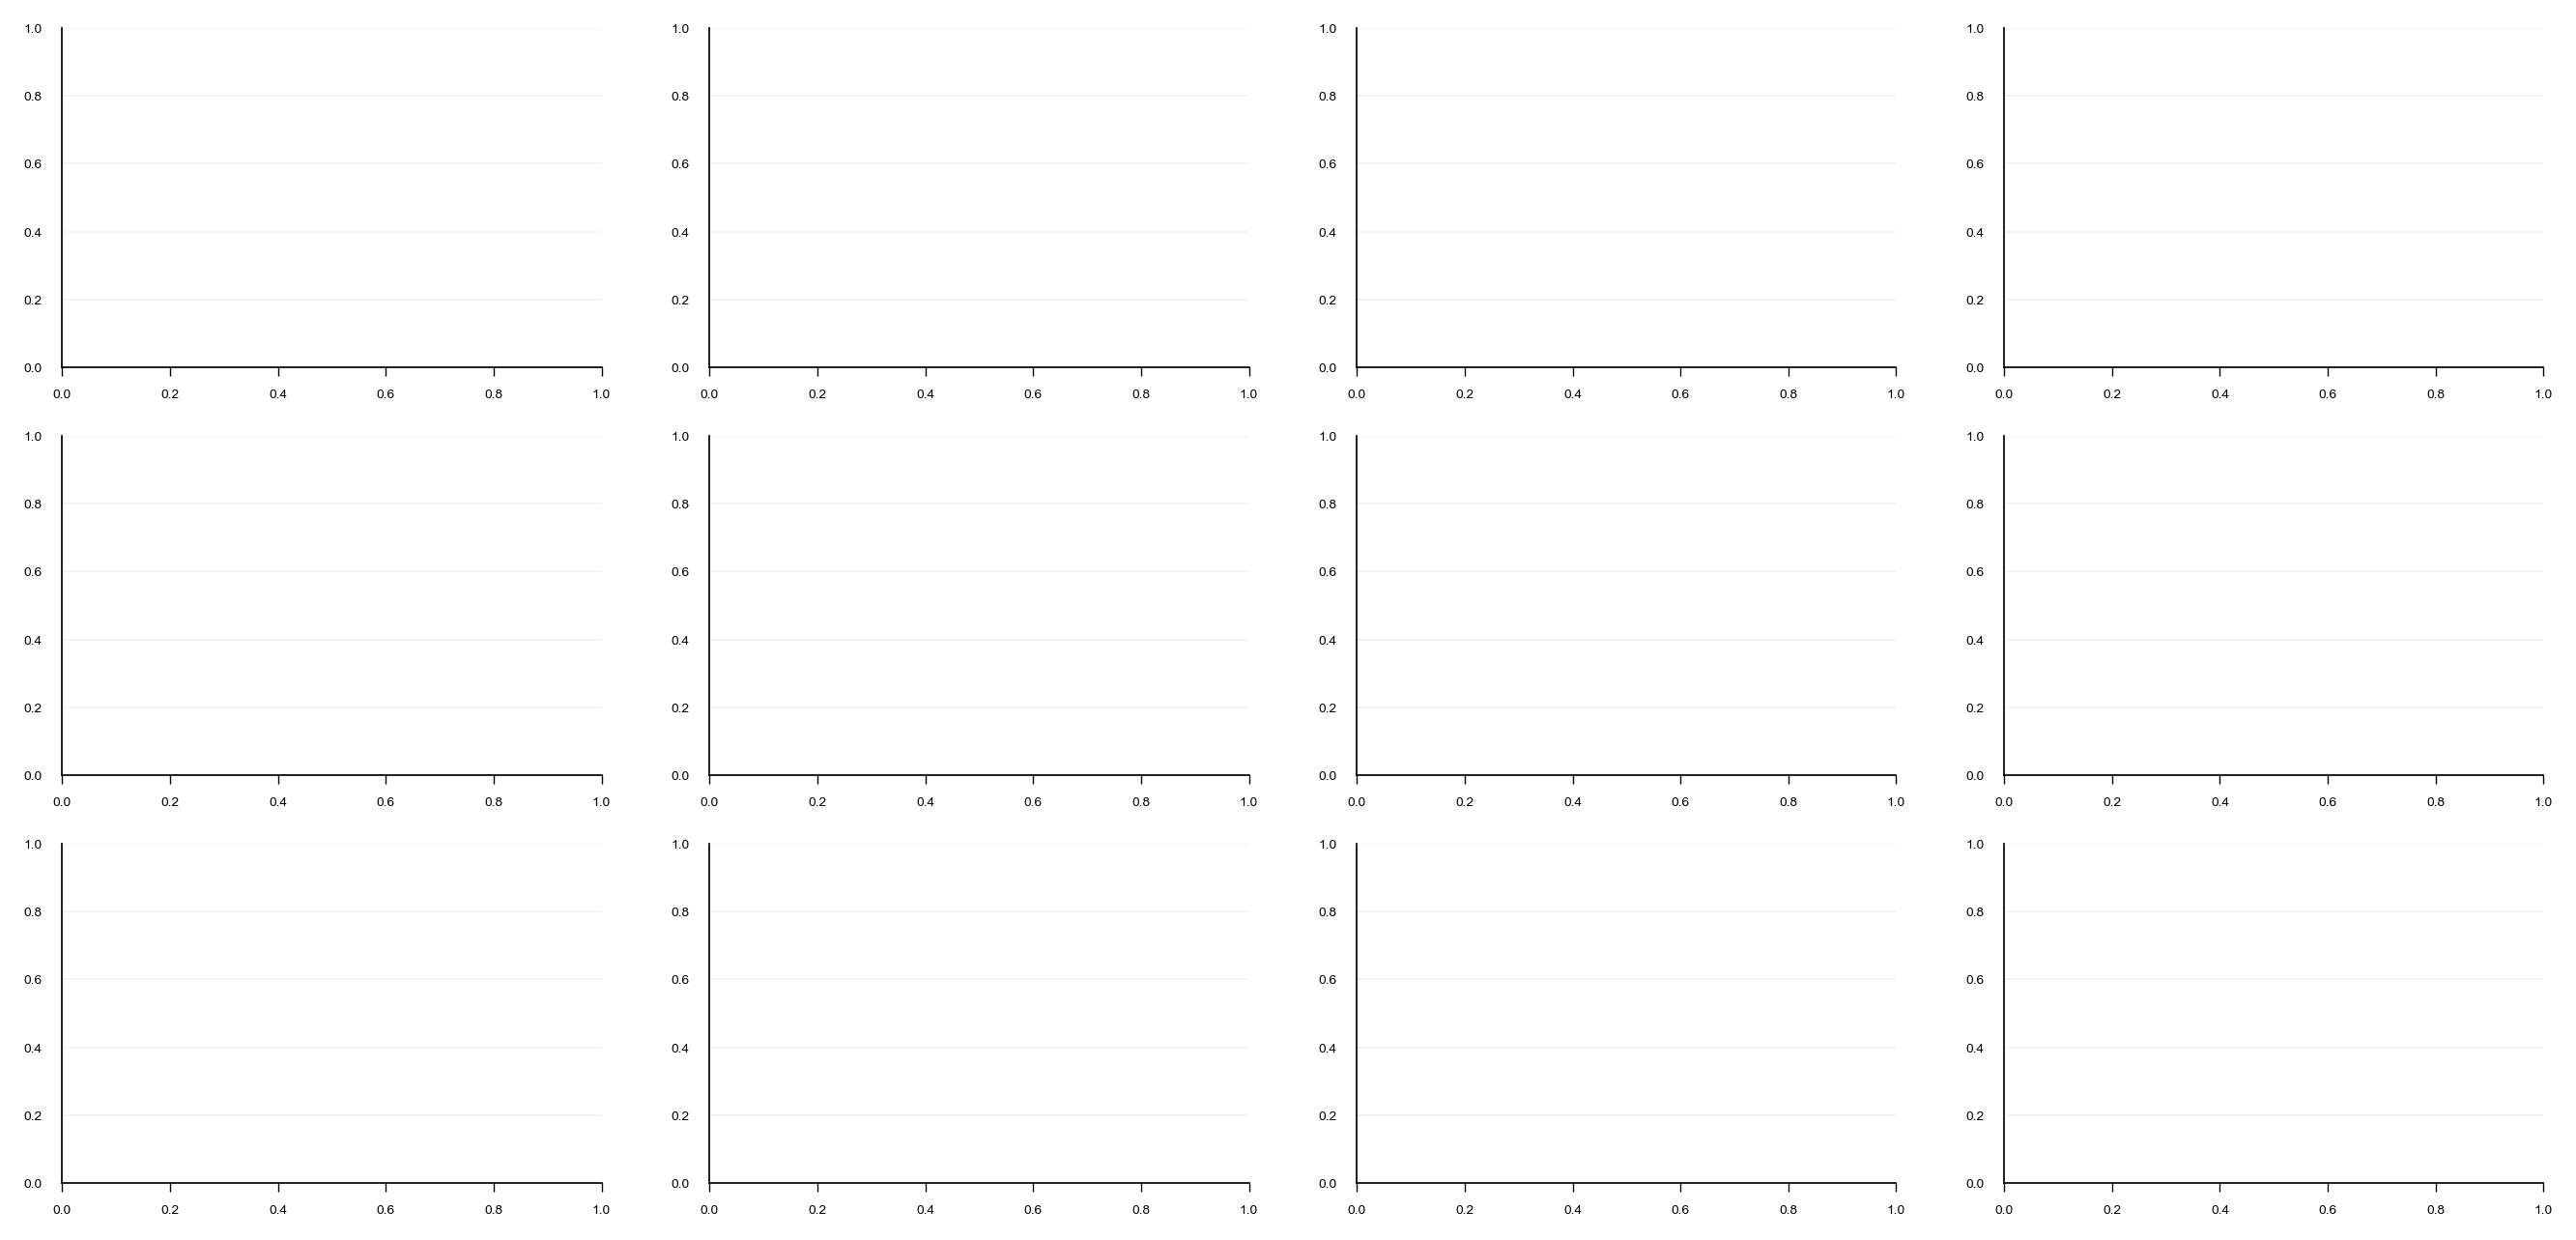

In [28]:
pplots.plot_relationship_to_target(df_imputed_for_plots, cols_num_discrete, target_col)

In [ ]:
proj_utils_plots.plot_relationship_to_target(df_imputed_for_plots, cols_num_discrete, target_col, trend_type='median')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train,
    df_raw_target,
    test_size=proj_configs.VALIDATION_SIZE,
    random_state=proj_configs.RANDOM_STATE
)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [ ]:
num_columns = cols_num_continuous
cat_columns = cols_cat_nominal + cols_cat_ordinal + cols_num_discrete + cols_binary + cols_object
tempo_columns = cols_temporal

In [ ]:
len(num_columns), len(cat_columns), len(tempo_columns)

In [ ]:
pproc_pipe = proj_utils_feat_engg.create_pproc_pipeline(num_columns, cat_columns, tempo_columns)

In [ ]:
# Login to mlflow
# mlflow.login()
# proj_utils_model.set_mlflow_uri("databricks")
# mlflow_experiment_name = f"/Users/asheesh.ambardar@live.com/{proj_configs.PROJECT_NAME}"
# mlflow_experiment_id = proj_utils_model.get_or_create_experiment(mlflow_experiment_name)
# proj_utils_model.set_mlflow_experiment(mlflow_experiment_name)
# model_uri = mlflow.get_artifact_uri(artefact_path)
# model_uri

In [ ]:
comet_experiment = comet_ml.Experiment()
# comet_experiment.set_name(proj_configs.PROJECT_NAME)

In [ ]:
# Verify connection
if comet_experiment.api_key:
    print("Successfully connected to Comet ML!")
else:
    print("Failed to connect to Comet ML")


In [ ]:
import warnings, logging
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
logging.getLogger("mlflow").setLevel(logging.ERROR)

In [ ]:
X_train_transformed = pproc_pipe.fit_transform(X_train)

In [ ]:
X_val_transformed = pproc_pipe.transform(X_val)

In [ ]:
y_train_transformed = y_train.to_numpy()
y_val_transformed = y_val.to_numpy()

In [ ]:
# Check for both NaN and None
has_nulls_or_nans = pd.isna(X_train_transformed).any()
print(f"Contains null or NaN values: {has_nulls_or_nans}")

In [ ]:
type(y_val)

In [ ]:
comet_experiment = comet_ml.Experiment()
run_name='xgb-10'
try:
    optimised_study_xgb = proj_utils_model.run_hyperparam_tuning_xgb_exp(X_train_transformed, y_train_transformed, X_val_transformed, y_val_transformed, comet_experiment, run_name, proj_configs.OPTUNA_TRIAL_COUNT)
finally:
    comet_experiment.end()

In [ ]:
import os
import pickle

def safe_load_model(model_path):
        try:
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"Model file not found at {model_path}")

            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            return model
        except (pickle.UnpicklingError, KeyError) as e:
            print(f"Error loading model: {str(e)}")
            print("This might be due to version mismatch or corrupted file")
            return None

# Load the model
model_path = f"{proj_configs.PATH_OUT_MODELS}xgb_model.pkl"
loaded_model = safe_load_model(model_path)

if loaded_model is not None:
    print("Model loaded successfully")

In [ ]:
loaded_model

In [ ]:
df_test = df_raw_all[df_raw_all['is_train']==0].iloc[:,:-1]

In [ ]:
df_test.sample(3)

In [ ]:
data_test_transformed = pproc_pipe.transform(df_test)
type(data_test_transformed)

In [ ]:
# Check for both NaN and None
has_nulls_or_nans = pd.isna(data_test_transformed).any()
print(f"Contains null or NaN values: {has_nulls_or_nans}")

In [ ]:
data_train_transformed = pproc_pipe.transform(df_train)
type(data_train_transformed)

In [ ]:
# Check for both NaN and None
has_nulls_or_nans = pd.isna(data_train_transformed).any()
print(f"Contains null or NaN values: {has_nulls_or_nans}")

In [ ]:
df_raw_target.shape

In [ ]:
data_target = df_raw_target.to_numpy()

In [ ]:
loaded_model.fit(data_train_transformed, data_target)

In [ ]:
train_preds = loaded_model.predict(data_train_transformed)
train_actuals = data_target

In [ ]:
type(train_preds)

In [ ]:
# Evaluate the model
train_mse = round(mean_squared_error(train_actuals, train_preds), 5)
train_r2 = round(r2_score(train_actuals, train_preds), 5)

print("=== Model Performance ===")
print(f"Train MSE: {proj_utils_plots.beautify(train_mse)}, Train R2: {proj_utils_plots.beautify(train_r2)}")

In [ ]:
test_preds = loaded_model.predict(data_test_transformed)

In [ ]:
test_preds

In [ ]:
df_my_submission = pd.DataFrame({'Id': df_raw_test.Id, 'SalePrice': test_preds})
my_submission_file = f"{proj_configs.PATH_OUT_SUBMISSIONS}submission.csv"
df_my_submission.to_csv(my_submission_file, index=False)

In [ ]:
# this is a Trial object, not the underlying ML object.
best_performing_trial = optimised_study_xgb.best_trial
print(f'Best trial was at number {proj_utils_plots.beautify(str(best_performing_trial.number), 1)} with params as:\n {proj_utils_plots.beautify(str(best_performing_trial.params), 2)}')
print(f'Best score value is: {proj_utils_plots.beautify(str(best_performing_trial.value))}')

In [ ]:
best_performing_trial

In [ ]:
study_full_metrics = optimised_study_xgb.trials_dataframe()
# save the metrics to a file
proj_utils_model.save_hyperparams(f'full_metrics_{proj_utils.get_current_timestamp()}.csv', proj_configs.PATH_OUT_MODELS, study_full_metrics)

# peek at the full metrics dataframe
study_full_metrics

In [ ]:
# fetch number of trial runs per model type
num_lr_trials = study_full_metrics[study_full_metrics['params_model'] == 'lr'].shape[0]
num_lasso_trials = study_full_metrics[study_full_metrics['params_model'] == 'lasso'].shape[0]
num_ridge_trials = study_full_metrics[study_full_metrics['params_model'] == 'ridge'].shape[0]
num_elasticnet_trials = study_full_metrics[study_full_metrics['params_model'] == 'elasticnet'].shape[0]

print(f'Total trials = {proj_utils_plots.beautify(str(num_lr_trials + num_lasso_trials + num_ridge_trials + num_elasticnet_trials), 1)}\n-- LR trials = {proj_utils_plots.beautify(str(num_lr_trials), 1)}\n-- Lasso trials = {proj_utils_plots.beautify(str(num_lasso_trials), 1)}\n-- Ridge trials = {proj_utils_plots.beautify(str(num_ridge_trials), 1)}\n-- ElasticNet trials = {proj_utils_plots.beautify(str(num_elasticnet_trials), 1)}')

In [ ]:
# retrieve all performance values for each model type studied
grp_by_model_type_val = study_full_metrics.groupby('params_model')['value'].apply(list)
# retrieve the best performing model (use nsmallest if Optuna objective was to minimise,
grp_by_model_type_best_val = study_full_metrics.groupby('params_model')['value'].nsmallest(1)
# display the stats
grp_by_model_type_best_val

In [ ]:
 # grouping Optuna metrics by model type and using idxmax (or idmin) method to find a row with the best model performance (value) for each group
study_best_model_group = study_full_metrics.loc[study_full_metrics.groupby('params_model')['value'].idxmin()]

In [ ]:
study_best_model_group

In [ ]:
# retrieve the trial number of the best model for each model type - the Optuna metrics dataframe index and trial number are the same.
best_lr_trial = study_best_model_group[study_best_model_group['params_model'] == 'lr']['number'].values[0]
best_lasso_trial = study_best_model_group[study_best_model_group['params_model'] == 'lasso']['number'].values[0]
best_ridge_trial = study_best_model_group[study_best_model_group['params_model'] == 'ridge']['number'].values[0]
best_elasticnet_trial = study_best_model_group[study_best_model_group['params_model'] == 'elasticnet']['number'].values[0]

final_pipe_best_lr = models[best_lr_trial]
best_model_lr = final_pipe_best_lr.named_steps['regressor']
final_pipe_best_lasso = models[best_lasso_trial]
best_model_lasso = final_pipe_best_lasso.named_steps['regressor']
final_pipe_best_ridge = models[best_ridge_trial]
best_model_ridge = final_pipe_best_ridge.named_steps['regressor']
final_pipe_best_elasticnet = models[best_elasticnet_trial]
best_model_elasticnet = final_pipe_best_elasticnet.named_steps['regressor']

# retrieve the best model object (amongst all model types evaluated)
final_pipe_best = models[best_performing_trial.number]
best_model = final_pipe_best.named_steps['regressor']

In [ ]:
final_pipe_best

In [ ]:
final_pipe_best.fit(X_train, y_train)

In [ ]:
cols_final_inputs, cols_final_output_features = proj_utils_feat_engg.get_final_features(final_pipe_best, X_train)

In [ ]:
proj_utils_model.save_features(f'pproc_final_input_cols_{len(cols_final_inputs)}_{proj_utils.get_current_timestamp()}.csv', proj_configs.PATH_OUT_FEATURES, pd.DataFrame(cols_final_inputs))
proj_utils_model.save_features(f'pproc_final_output_features_{len(cols_final_output_features)}_{proj_utils.get_current_timestamp()}.csv', proj_configs.PATH_OUT_FEATURES, pd.DataFrame(cols_final_output_features))

In [ ]:
proj_utils_model.save_model(f'final_pipe_{proj_utils.get_current_timestamp()}.pkl', proj_configs.PATH_OUT_MODELS, final_pipe_best)

In [ ]:
y_train_preds = final_pipe_best.predict(X_train)
y_val_preds = final_pipe_best.predict(X_val)

In [ ]:
# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_preds).round(5)
val_mse = mean_squared_error(y_val, y_val_preds).round(5)
train_r2 = r2_score(y_train, y_train_preds).round(5)
val_r2 = r2_score(y_val, y_val_preds).round(5)

print("=== Model Performance ===")
print(f"Train MSE: {proj_utils_plots.beautify(train_mse)}, Train R2: {proj_utils_plots.beautify(train_r2)}")
print(f"Validation MSE: {proj_utils_plots.beautify(val_mse)}, Validation R2: {proj_utils_plots.beautify(val_r2)}")

In [ ]:
string_to_log = f'=== Model Performance === \n Train MSE: {train_mse}, Train R2: {train_r2} \n Validation MSE: {val_mse}, Validation R2: {val_r2}'
proj_utils.save_file('metrics', 'validation_metrics.txt', proj_configs.PATH_OUT_MODELS, string_to_log)